In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
LibraryPathWindows = r"D:\Учеба\Практика\Диплом\gamma"
LibraryPathLinux = r"/home/danis/work/python_works/gamma"
sys.path.insert(0, LibraryPathWindows)
sys.path.insert(0, LibraryPathLinux)

In [3]:
from SpectrumsMeasurementsLibrary.GammaRayInteractions.Materials import Material, R
from SpectrumsMeasurementsLibrary.CrossSectionsLibrary.cross_sections_data import ENERGY_MESH
from SpectrumsMeasurementsLibrary.MeasurementInstrumentation.measurement_techniques import ideal_transmission_function, \
k_edge_method_transmission_function, ross_method_transmission_function, edges_indices

In [4]:
brem = R(50, 1e-2).emitted_bremsstrahlung(0.075)

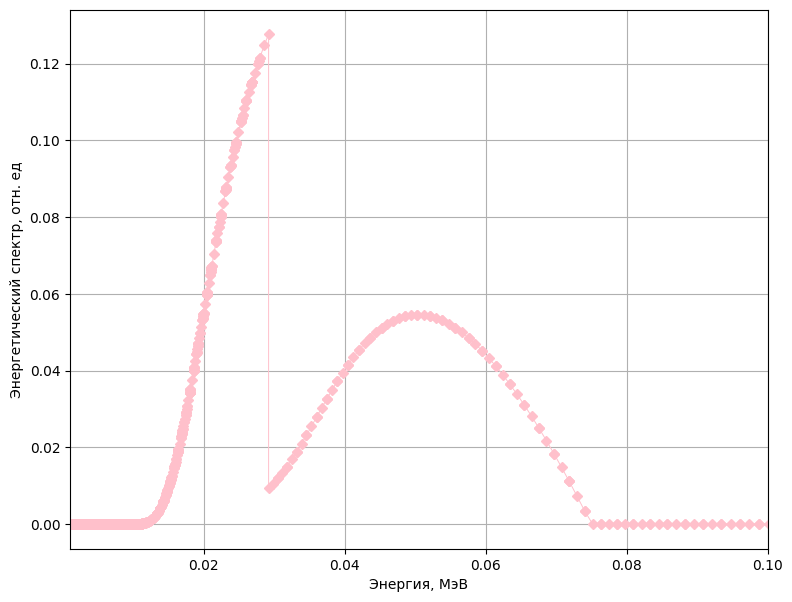

In [5]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(ENERGY_MESH, brem, ls='-', marker='D', lw='0.7', ms=5, color='pink')

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=10)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.10e0)
# ax.set_ylim(1e-7, 1.2)

ax.grid(True)

# fig.savefig('Тормозной спектр.jpg', bbox_inches='tight')

In [6]:
first_channel = 11
last_channel = 100 
number_of_channels = last_channel - first_channel
number_of_channels_with_open_detector = 1

In [71]:
level = 0.2

In [92]:
EDGE_METHOD_channels = [k_edge_method_transmission_function(num, level) for num in range(first_channel, last_channel+1)]
IDEAL_channels = [ideal_transmission_function(num, num+1, level) for num in range(first_channel, last_channel)]
ROSS_METHOD_channels = [ross_method_transmission_function(num, num+1, level) for num in range(first_channel, last_channel)]

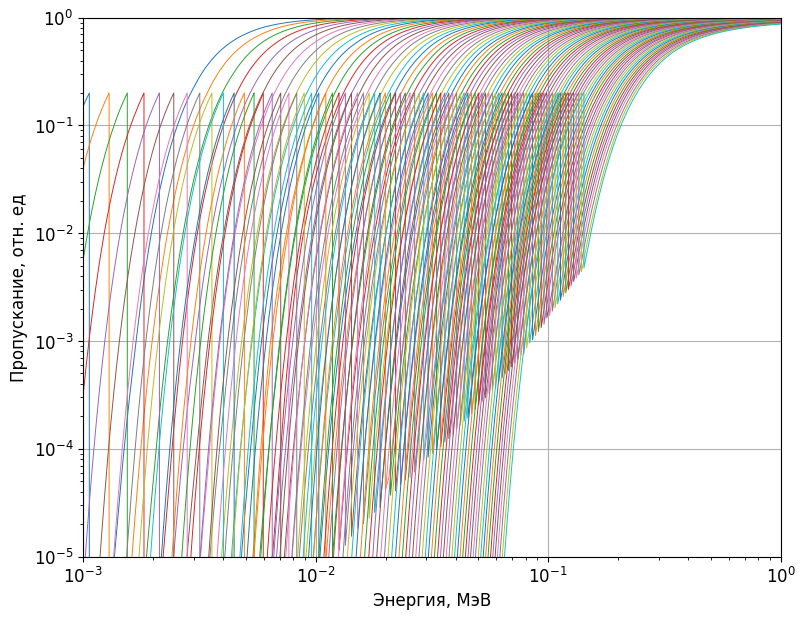

In [73]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in EDGE_METHOD_channels:
    ax.plot(ENERGY_MESH, i, ls='-', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Пропускание, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-3, 1e0)
ax.set_ylim(1e-5, 1e0)
ax.grid(True)

# fig.savefig('Краевые фильты СХЧ.svg', bbox_inches='tight')

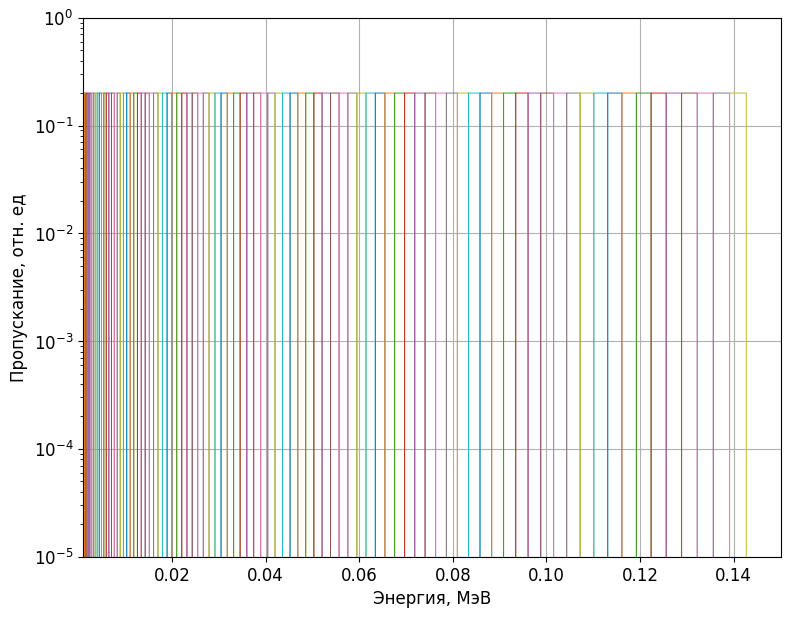

In [74]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in IDEAL_channels:
    ax.plot(ENERGY_MESH, i, ls='-', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Пропускание, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
# ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-3, 0.15e0)
ax.set_ylim(1e-5, 1e0)
ax.grid(True)

# fig.savefig('Краевые фильты СХЧ.svg', bbox_inches='tight')

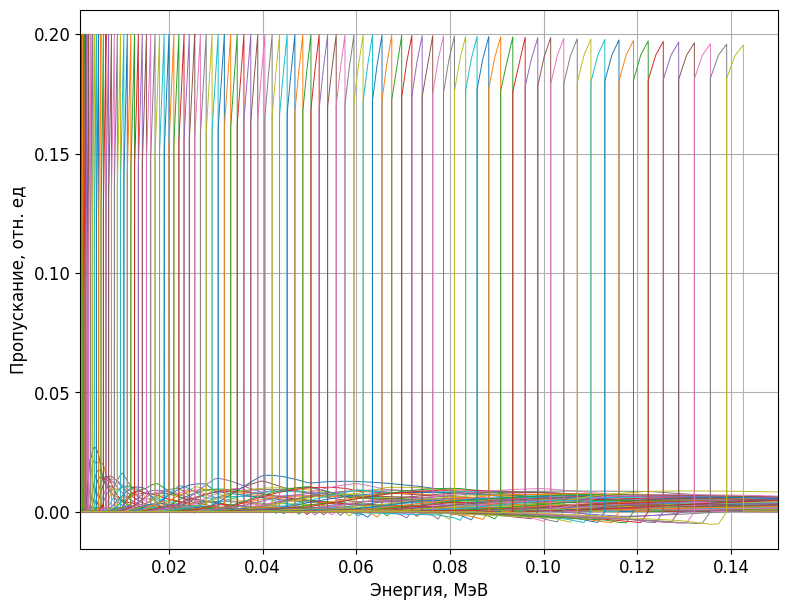

In [95]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in ROSS_METHOD_channels:
    ax.plot(ENERGY_MESH, i, ls='-', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Пропускание, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlim(1e-3, 0.15e0)
# ax.set_ylim(1e-5, 1e0)
ax.grid(True)

# fig.savefig('Краевые фильты СХЧ.svg', bbox_inches='tight')

In [96]:
def split(array):
    """
    Разделяет массив на части по три элемента
    (нужно переделать функцию)
    """
    if not len(array) % 3:
        energy_mesh = np.copy(ENERGY_MESH)
        area_num = len(energy_mesh) / 3
        return np.split(energy_mesh, area_num)

    else: # если длинна массива не кратна трем убирается последняя точка
        energy_mesh = np.copy(ENERGY_MESH[:-1])
        area_num = len(energy_mesh) / 3
        return np.split(energy_mesh, area_num)

In [97]:
def polinom_coeff_h(simple_area):
    x = simple_area
    x21 = x[2]-x[1]
    x20 = x[2]-x[0]
    x10 = x[1]-x[0]
    c0 = (1/6)*x20
    c1 = (4/6)*x20
    c2 = (1/6)*x20
    return [c0, c1, c2]

In [98]:
EDGES = edges_indices()

In [99]:
EDGES.remove(EDGES[EDGES.index(Material(50).k_edge_index())])

In [100]:
len(EDGES)

563

In [101]:
!pip install scipy
from scipy import linalg

You should consider upgrading via the '/home/danis/work/python_works/gamma/env/bin/python -m pip install --upgrade pip' command.


In [102]:
def Gold(A, b, en, init_spectrum, dec_en, x0=False, it=None, w=False, d=False):
    A = np.array(A)
    b = np.array(b)
    b = b.reshape(len(b), -1)

    def deviation(init_spectrum, dec_spectrum):
        dec_spectrum_on_init_grid = np.interp(en, dec_en, dec_spectrum)
        different = [(i - j) ** 2 for i, j in zip(dec_spectrum_on_init_grid, init_spectrum)]
        init_sq = [val ** 2 for val in init_spectrum]

        def integral_t(different_signal, grid):
            s = 0
            for i in range(1, len(different_signal) - 2):
                s += (grid[i] - grid[i - 1]) * different_signal[i - 1]
            return s

        dev = integral_t(different, en) / integral_t(init_sq, en)
        return dev

    # Если начальное приближение не задано создает вектор-столбец x0 = [1, 1,.., 1]
    if x0:
        previous_x = np.ones((A.shape[1], 1), dtype=np.float64)
    # Транспонирование вектора х0, если он считывается вектором-строкой
    else:
        x0 = float(input('Введите начальное приближение: '))
        previous_x = x0 * np.ones((A.shape[1], 1), dtype=np.float64)
    # Транспонирование вектора b, если он считывается вектором-строкой
    if b.shape[1] != 1:
        b = b.T
    if it is None:
        num_of_iter = int(input('Введите число итераций: '))
    else:
        num_of_iter = it

    if w == False:
        W = np.diag([float(1 ** 2) for i in range(0, len(b))])
    if w == True:
        W = np.diag([float(i) for i in range(0, len(b))])

    current_x = np.ones((A.shape[1], 1), dtype=np.float64)
    norm_list = []
    deviation_list = []

    # Основной цикл алгоритма Голда
    for k in range(0, num_of_iter + 1):
        # Создание матрицы Y = A.T * W.T * W * b
        Y = np.dot(A.T, np.dot(W.T, np.dot(W, b)))
        # Создание матрицы AX = A.T * W.T * W * A * x
        AX = np.dot(A.T, np.dot(W.T, np.dot(W, np.dot(A, previous_x))))
        AX[AX == 0] = np.nextafter(0, 1)*1e20
        current_x = 1.0 * previous_x + (previous_x / AX) * (Y - AX)
        previous_x = current_x

        norm_list.append(linalg.norm(np.dot(A, current_x) - b))
        if d == True:
            deviation_list.append(deviation(init_spectrum, current_x.reshape(1, -1)[0].tolist()) ** 0.5)

    norm = [range(1, num_of_iter + 2), norm_list]

    if d == True:
        dev = [range(1, num_of_iter + 2), deviation_list]
    if d == False:
        dev = deviation(init_spectrum, current_x.reshape(1, -1)[0].tolist())**0.5


    current_x = current_x.reshape(1, -1)
    current_x = current_x[0].tolist()

    return current_x, norm, dev
    


def get_coeff_simpson(responce, grid, EDGE, min_index=None, max_index=None):
    simpson_coeff_list = []
    new_energy = []

    if min_index is None:
        min_index = 0
    if max_index is None:
        max_index = len(grid) - 2

    reverse = False
    def write():
        simpson_coeff_list.append(simpson)
        new_energy.append(grid[i])

    RIGHT_EDGE = [val+1 for val in EDGE]

    for i in range(min_index, max_index):
        if i not in RIGHT_EDGE:
            if i == min_index:
                simpson = (1/6)*(grid[i+2] - grid[i])*responce[i]
                write()
            if i == max_index - 1:
                simpson = (1/6)*(grid[i+2] - grid[i])*responce[i]
                write()

            # если i нечетное
            if i % 2 != 0 and i != min_index and i != max_index - 1:
                # если РЕВЕРС отключен
                if reverse == False:
                    # если i-скачок
                    if i in EDGE:
                        simpson = (1/2)*(grid[i]-grid[i-1])*responce[i] + (1/6)*(grid[i+3]-grid[i+1])*responce[i+1] # К-нечетное-скачок
                        write()
                        continue
                    # если i без скачка
                    if i not in EDGE:
                        simpson = (4/6)*(grid[i+1]-grid[i-1])*responce[i] # К-нечетное
                        write()
                # если РЕВЕРС включен
                if reverse == True:
                    # если i-скачок
                    if i in EDGE:
                        simpson = (1/6)*(grid[i]-grid[i-2])*responce[i] + (1/6)*(grid[i+3]-grid[i+1])*responce[i+1] # К-четное-скачок
                        write()
                        reverse = False
                        continue
                    # если i без скачка
                    if i not in EDGE:
                        simpson = (1/6)*(grid[i]-grid[i-2])*responce[i] + (1/6)*(grid[i+2]-grid[i])*responce[i] # К-четное
                        write()

            # если i-четное
            if i % 2 == 0 and i != min_index and i != max_index - 1:
                # если РЕВЕРС отключен
                if reverse == False:
                    # если i-скачок
                    if i in EDGE:
                        simpson = (1/6)*(grid[i]-grid[i-2])*responce[i] + (1/6)*(grid[i+3]-grid[i+1])*responce[i+1] # К-четное-скачок
                        write()
                        reverse = True
                        continue
                    # если i без скачка
                    if i not in EDGE:
                        simpson = (1/6)*(grid[i]-grid[i-2])*responce[i] + (1/6)*(grid[i+2]-grid[i])*responce[i] # К-четное
                        write()
                # если РЕВЕРС включен
                if reverse == True:
                    # если i-скачок
                    if i in EDGE:
                        simpson = (1/2)*(grid[i]-grid[i-1])*responce[i] + (1/6)*(grid[i+3]-grid[i+1])*responce[i+1] # К-нечетное-скачок
                        write()
                        continue
                    # если i без скачка
                    if i not in EDGE:
                        simpson = (4/6)*(grid[i+1]-grid[i-1])*responce[i] # К-нечетное
                        write()

        if i in RIGHT_EDGE:
            continue

    return simpson_coeff_list, new_energy

In [103]:
signals_simpson = [sum(get_coeff_simpson(brem*r, ENERGY_MESH, EDGES)[0]) for r in ROSS_METHOD_channels]

In [106]:
e1 = [Material(i).k_edge_energy() for i in range(11, 100)]
e2 = [val for val in e1]
e3 = (np.array(e2)+np.array(e1))/2

In [107]:
mean_spectrum = np.array(signals_simpson) / e3

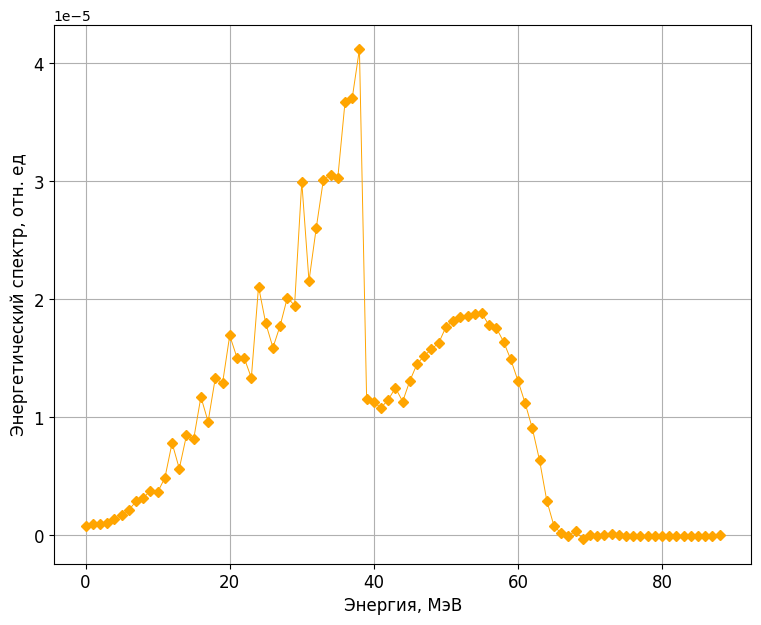

In [108]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(list(range(len(signals_simpson))), signals_simpson, ls='-', marker='D', lw='0.7', ms=5, color='orange')
# ax.plot(e3, mean_spectrum, ls='-', marker='D', lw='0.7', ms=5, color='orange')
# ax.plot(en, brem_e, ls='-', marker='D', lw='0.7', ms=5, color='pink')

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1e-3, 1e-1)
# ax.set_ylim(1e-15, 1.2)
ax.grid(True)

In [112]:
Matrix = [get_coeff_simpson(response, ENERGY_MESH, EDGES)[0] for response in ROSS_METHOD_channels]

In [113]:
sp = [0 for i in range(len(signals_simpson))]
norm = [0 for i in range(len(signals_simpson))]
decb = [0 for i in range(len(signals_simpson))]
dev = [0 for i in range(len(signals_simpson))]

new_en = get_coeff_simpson(IDEAL_channels[0], ENERGY_MESH, EDGES)[1]

In [114]:
import time
# восстановление спектра методом Голда на основании К-фильтров
start_time = time.time()
sp, norm, dev = Gold(Matrix, signals_simpson, ENERGY_MESH, brem, new_en, 1, 30000, w=True, d=False)[:3]

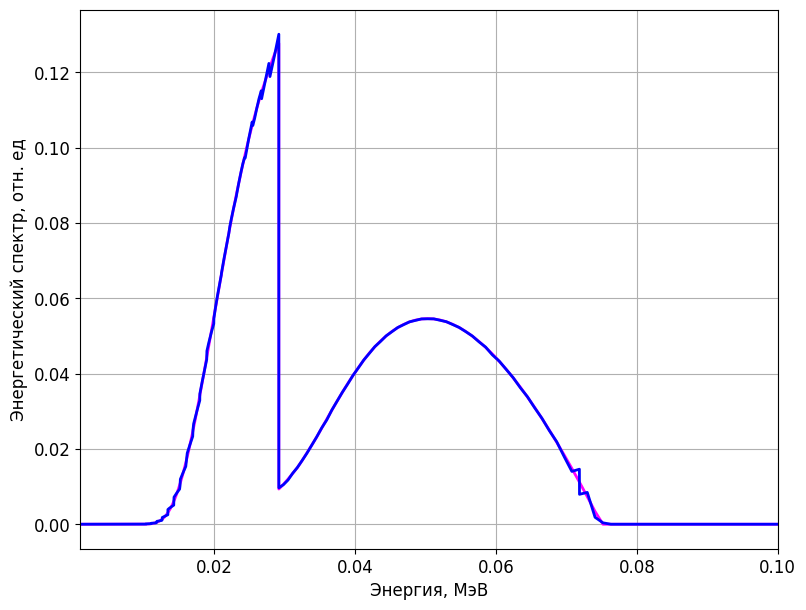

In [115]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(ENERGY_MESH, brem, ls='-', lw='2', ms=5, color='magenta')
ax.plot(new_en, sp, ls='-', lw='2', ms=5, color='blue')


# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.10e0)
# ax.set_ylim(1e-7, 1.2)
ax.grid(True)

In [116]:
dev

0.012856652645092278

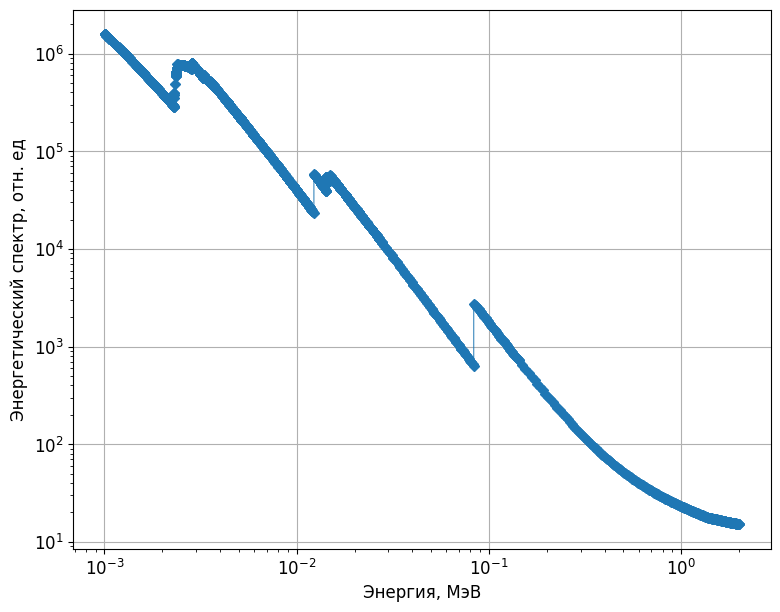

In [150]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(ENERGY_MESH, Material(80).cs('total'), ls='-', marker='D', lw='0.7', ms=5)
    
# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(1e-2, 1.5e-2)
# ax.set_ylim(1e-7, 1.2)
ax.grid(True)

In [136]:
Material(50).k_edge_energy()

0.029184